# Kalbėtojo atpažinimas naudojant mašininį mokymąsi

In [6]:
import os
import numpy as np
import librosa
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Features from short signals with zero-padding
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    min_len = 2048  # minimum for n_fft functions
    if len(y) < min_len:
        y = np.pad(y, (0, min_len - len(y)))

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=512)

    y_harm = librosa.effects.harmonic(y)
    if len(y_harm) < min_len:
        y_harm = np.pad(y_harm, (0, min_len - len(y_harm)))
    tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)

    features = np.hstack([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(chroma, axis=1), np.std(chroma, axis=1),
        np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1)
    ])
    return features

# Load dataset
X, y = [], []
audio_files = glob("/content/drive/MyDrive/MSc Vilnius TECH/II Semester/Šnekos analizė/dataset/*/*.wav")  # <- pakeisk jei tavo kelias kitoks

for path in audio_files:
    label = os.path.basename(os.path.dirname(path))
    features = extract_features(path)
    X.append(features)
    y.append(label)

# Encode and prepare
X = np.array(X)
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train & evaluate SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")


Accuracy: 100.00%


## Gauti rezultatai po apmokymo

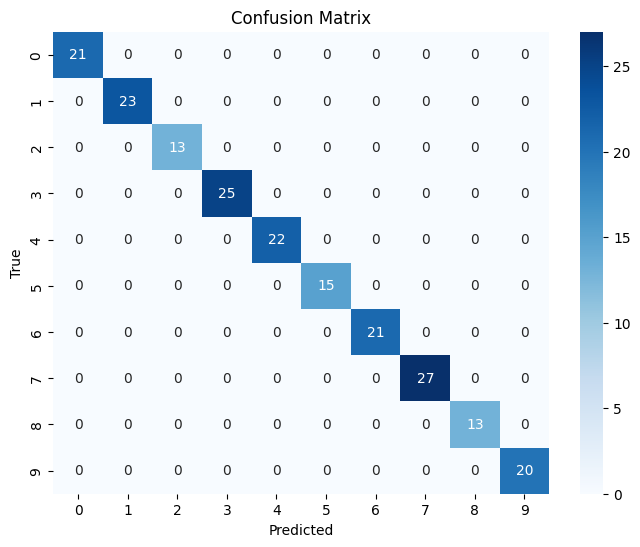


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-val accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

Cross-val accuracy: 1.00 ± 0.00


## *White noise* pridėjimas

In [17]:
# Add white noise to test features
def add_noise(features, noise_level=0.05):
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

X_test_noisy = add_noise(X_test, noise_level=2)

# Evaluate on noisy data
y_pred_noisy = clf.predict(X_test_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
print(f"Noisy accuracy: {acc_noisy * 100:.2f}%")


Noisy accuracy: 79.50%
